In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import math
from matplotlib import gridspec
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

In [4]:
# Load data
df = pd.read_csv('../data/HR_data.csv')

emotions_columns = ["Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]

phys_var_columns = ['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std',
       'HR_TD_Min', 'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope',
       'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min',
       'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew',
       'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
       'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std',
       'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max',
       'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_ReT']


df_phase2 = df[df['Phase'] == 'phase2']

df_emotions = df_phase2[emotions_columns]
df_phys = df_phase2[phys_var_columns]

Correlaciones canónicas:
  Componente 1: 0.898
  Componente 2: 0.891

Pesos de las variables de X en cada componente U (interpretación de X):
                  U1        U2
Frustrated -0.490091 -0.460355
upset       0.021165  0.127483
hostile    -0.095162  0.558130
alert      -0.049005 -0.401897
ashamed     0.609670 -0.018847
inspired   -0.186900 -0.067690
nervous    -0.201290  0.297311
attentive   0.209976  0.066022
afraid     -0.141614 -0.159484
active     -0.419142  0.192751
determined  0.246847 -0.372174

Pesos de las variables de Y en cada componente V (interpretación de Y):
                           V1        V2
HR_TD_Mean          -0.055364 -0.001155
HR_TD_Median         0.027008 -0.001934
HR_TD_std            0.022055  0.043940
HR_TD_Min            0.014942  0.016413
HR_TD_Max           -0.018896 -0.028827
HR_TD_AUC            0.026150  0.000672
HR_TD_Kurtosis       0.010207  0.008440
HR_TD_Skew          -0.002246 -0.011268
HR_TD_Slope_min     -0.007545  0.008423
HR_TD_Slope_m

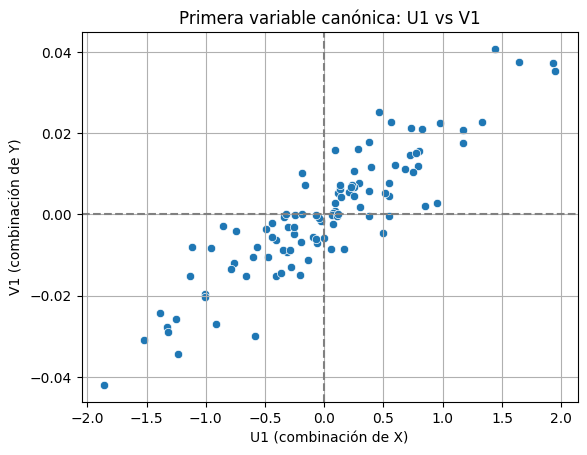

In [7]:
# Estandarizar los datos (muy importante en CCA)
scaler_X = StandardScaler()
scaler_Y  = StandardScaler()
df_emotions_scaled = scaler_X.fit_transform(df_emotions)
df_phys_scaled = scaler_Y .fit_transform(df_phys)

# Aplicar CCA
cca = CCA(n_components=2)
df_emotions_c, df_phys_c = cca.fit_transform(df_emotions_scaled, df_phys_scaled)

# Correlaciones canónicas
canonical_corrs = [np.corrcoef(df_emotions_c[:, i], df_phys_c[:, i])[0, 1] for i in range(cca.n_components)]
print("Correlaciones canónicas:")
for i, c in enumerate(canonical_corrs):
    print(f"  Componente {i+1}: {c:.3f}")

# Pesos o coeficientes (interpretación de variables originales)
x_loadings = pd.DataFrame(cca.x_weights_, index=df_emotions.columns, columns=[f"U{i+1}" for i in range(cca.n_components)])
y_loadings = pd.DataFrame(cca.y_weights_, index=df_phys.columns, columns=[f"V{i+1}" for i in range(cca.n_components)])

print("\nPesos de las variables de X en cada componente U (interpretación de X):")
print(x_loadings)

print("\nPesos de las variables de Y en cada componente V (interpretación de Y):")
print(y_loadings)

# Correlación de cada variable original con cada variable canónica (más interpretable)
X_c_df = pd.DataFrame(df_emotions_c, columns=[f"U{i+1}" for i in range(cca.n_components)])
Y_c_df = pd.DataFrame(df_phys_c, columns=[f"V{i+1}" for i in range(cca.n_components)])

X_corrs = pd.DataFrame(np.corrcoef(df_emotions_scaled.T, df_emotions_c.T)[:df_emotions.shape[1], df_emotions.shape[1]:], 
                       index=df_emotions.columns, columns=X_c_df.columns)

Y_corrs = pd.DataFrame(np.corrcoef(df_phys_scaled.T, df_phys_c.T)[:df_phys.shape[1], df_phys.shape[1]:], 
                       index=df_phys.columns, columns=Y_c_df.columns)

print("\nCorrelaciones entre variables originales de X y variables canónicas U:")
print(X_corrs)

print("\nCorrelaciones entre variables originales de Y y variables canónicas V:")
print(Y_corrs)

# Visualización conjunta del primer par de variables canónicas
sns.scatterplot(x=X_c_df["U1"], y=Y_c_df["V1"])
plt.title("Primera variable canónica: U1 vs V1")
plt.xlabel("U1 (combinación de X)")
plt.ylabel("V1 (combinación de Y)")
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()